### Load packages and sample data

In [1]:
import re
import pandas as pd
from typing import List
import utils

Using state Catalonia server backend.


In [2]:
fields_to_include = ["OWNER","TITLE", "ABSTRACT", "SERVICETYPE", "SERVICELINK", "KEYWORDS"]
fields_to_output = ["OWNER","TITLE", "SERVICETYPE", "SERVICELINK"]
url_github_repo = "https://github.com/davidoesch/geoservice_harvester_poc/blob/main/data/"
url_github_repo_suffix = "?raw=true"
url_geoservices_CH_csv = "{}geoservices_CH.csv{}".format(url_github_repo,url_github_repo_suffix)
a = 'Strassen auswertung system'

def split_delimiters(word_list_with_delimiters: List[str]) -> List[str]:
    """Take care of left over delimiters, split strings even if in qoutes
        Return a list of words """
    delimiters = [";", ","]

    new_word_list = []

    for word in word_list_with_delimiters:
        if (any(delimiter in word for delimiter in delimiters)):
            splitted_words = re.split(r',|;', word)
            for splitted_word_ in splitted_words:
                new_word_list.append(splitted_word_)
        else:
            new_word_list.append(word)
    return new_word_list

def load_data():
    dataframe = pd.read_csv(url_geoservices_CH_csv, usecols=fields_to_include)
    return dataframe

# res = split_delimiters(shlex.split(a))
dataframe_some_cols = load_data()
# result = dataframe_some_cols[dataframe_some_cols.apply(lambda dataset: dataset.astype(str).str.contains(res[0], case=False).any(), axis=1)]
# database =result.fillna("empty")
database = dataframe_some_cols.fillna("nan")

### Improvement of the TF-IDF with BM25 to execute queries on the text

In [7]:
# abstracts = result['ABSTRACT'].values.tolist()
bm25 = utils.TFIDF_BM25()
bm25.cleansing_ranking(database, column='ABSTRACT') # 1421 lines in 36 s

In [6]:
# fit the vector to the database
bm25.fit()
# search the best match in the vector
res = bm25.search('Brandmeldeanlage')

In [7]:
for el in res:
    print(result.loc[el])

OWNER                                                      KT_AR
TITLE                                          Feuerwehrplan Gde
ABSTRACT       Der Übersichtsplan der Feuerwehr enthält folge...
KEYWORDS                                                     NaN
SERVICELINK    https://www.geoportal.ch/services/wms/ktar?ser...
SERVICETYPE                                                  WMS
Name: 224, dtype: object


### Implement the classification and keyword extraction with spacy (NLP)

In [22]:
NLP = utils.NLP_spacy()
# Keyword
keywords_NLP = NLP.extract_keywords(database, column='ABSTRACT') # with small models

In [28]:
keywords_NLP[0]

[Geoportal]

In [15]:
# Original abstract
database['ABSTRACT'].values.tolist()[0]

'Diese Karte zeigt die Werkleitungen der Abwasserentsorgung an. Es wird die Strassenentwässerung und Liegenschaftsentwässerung (teilweise mit Hausanschluss) sowie das Kanalisationsnetz dargestellt. Darin ersichtlich sind unter anderem Leitungen mit Schmutzabwasser, Mischabwasser, Regenabwasser, Meteorwasser sowie Versickerungsanlagen, Kontrollschächte, Einlaufschächte und Ölabscheider. WMS Service Geoportal - Kanton Appenzell Innerrhoden'

### Test LSA and LSI with gensim for topic modelling

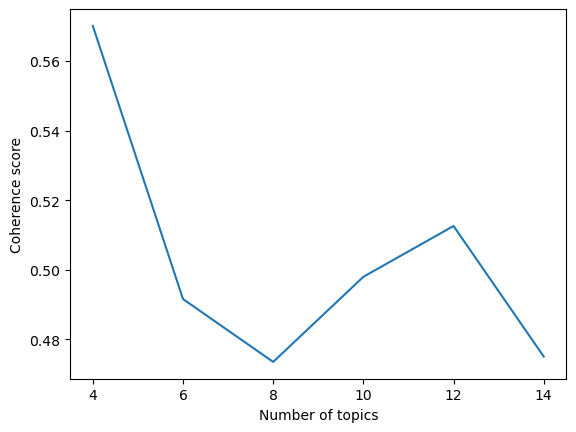

In [3]:
LSA = utils.LSI_LDA()
abstracts = LSA.preprocess(database)
LSA.compute_coherence_values_LSI((4,16,2))

In [8]:
best_number_topics = 12
number_of_words = 20
lsamodel = LSA.create_gensim_lsa_model(best_number_topics, number_of_words)

[(0, '-0.439*"art" + -0.433*"tvav" + -0.239*"enthalt" + -0.209*"dateneb" + -0.199*"definiert" + -0.192*"punkt" + -0.172*"fehl" + -0.172*"mittl" + -0.172*"toleranzstuf" + -0.172*"standardabweich" + -0.172*"richt" + -0.165*"kategori" + -0.144*"lagegenau" + -0.115*"bzw." + -0.096*"grenzpunkt" + -0.089*"geeignet" + -0.088*"auss" + -0.088*"zuverlass" + -0.088*"kenngross" + -0.088*"nachgewies"'), (1, '-0.416*"kanton" + -0.292*"wurd" + -0.281*"bern" + -0.232*"datensatz" + -0.230*"https" + -0.209*"//geofiles.be.ch/geoportal/pub/vertrieb/agi_dv_nutzungsbedingungen_de.pdf" + -0.147*"\'\'" + -0.146*"``" + -0.138*"gemass" + -0.129*"fff" + -0.129*"kantonal" + -0.121*"flach" + -0.116*"sitz" + -0.111*"gewasserraum" + -0.101*"strass" + -0.099*"grenz" + -0.094*"dat" + -0.092*"enthalt" + -0.089*"gemeind" + -0.088*"generalisiert"'), (2, '-0.436*"sitz" + 0.335*"\'\'" + 0.333*"``" + -0.326*"bern" + 0.306*"datensatz" + -0.147*"https" + -0.142*"//geofiles.be.ch/geoportal/pub/vertrieb/agi_dv_nutzungsbedingung

In [9]:
lsamodel.print_topics(best_number_topics, number_of_words)

[(0,
  '-0.439*"art" + -0.433*"tvav" + -0.239*"enthalt" + -0.209*"dateneb" + -0.199*"definiert" + -0.192*"punkt" + -0.172*"fehl" + -0.172*"mittl" + -0.172*"toleranzstuf" + -0.172*"standardabweich" + -0.172*"richt" + -0.165*"kategori" + -0.144*"lagegenau" + -0.115*"bzw." + -0.096*"grenzpunkt" + -0.089*"geeignet" + -0.088*"auss" + -0.088*"zuverlass" + -0.088*"kenngross" + -0.088*"nachgewies"'),
 (1,
  '-0.416*"kanton" + -0.292*"wurd" + -0.281*"bern" + -0.232*"datensatz" + -0.230*"https" + -0.209*"//geofiles.be.ch/geoportal/pub/vertrieb/agi_dv_nutzungsbedingungen_de.pdf" + -0.147*"\'\'" + -0.146*"``" + -0.138*"gemass" + -0.129*"fff" + -0.129*"kantonal" + -0.121*"flach" + -0.116*"sitz" + -0.111*"gewasserraum" + -0.101*"strass" + -0.099*"grenz" + -0.094*"dat" + -0.092*"enthalt" + -0.089*"gemeind" + -0.088*"generalisiert"'),
 (2,
  '-0.436*"sitz" + 0.335*"\'\'" + 0.333*"``" + -0.326*"bern" + 0.306*"datensatz" + -0.147*"https" + -0.142*"//geofiles.be.ch/geoportal/pub/vertrieb/agi_dv_nutzungsb

### Test Text Summarization and Latent Dirchlet allocation (LDA) for topic modeling

In [16]:
# https://towardsdatascience.com/text-summarization-for-clustering-documents-2e074da6437a
# https://towardsdatascience.com/nlp-topic-modeling-to-identify-clusters-ca207244d04f

# https://medium.com/plain-simple-software/build-an-ai-text-summarizer-in-python-6209fb23875d

#### Keywords extraction

In [3]:
NLP = utils.NLP_spacy()
keywords_dataset = NLP.extract_refined_keywords(database, use_rake=True, column='ABSTRACT',
                                          keyword_length=3, num_keywords=15)

Wxtracting keywords with RAKE...
Finalizing the keywords with SpaCy...
Finalizing the keywords with SpaCy...
Finalizing the keywords with SpaCy...
Finalizing the keywords with SpaCy...
Finalizing the keywords with SpaCy...
Finalizing the keywords with SpaCy...
Finalizing the keywords with SpaCy...
Finalizing the keywords with SpaCy...
Finalizing the keywords with SpaCy...
Finalizing the keywords with SpaCy...
Finalizing the keywords with SpaCy...
Finalizing the keywords with SpaCy...
Finalizing the keywords with SpaCy...
Finalizing the keywords with SpaCy...
Finalizing the keywords with SpaCy...
Finalizing the keywords with SpaCy...
Finalizing the keywords with SpaCy...
Finalizing the keywords with SpaCy...
Finalizing the keywords with SpaCy...
Finalizing the keywords with SpaCy...
Finalizing the keywords with SpaCy...
Finalizing the keywords with SpaCy...
Finalizing the keywords with SpaCy...
Finalizing the keywords with SpaCy...
Finalizing the keywords with SpaCy...
Finalizing the ke

In [6]:
keywords_dataset[1]

['ar', 'ai', 'kantonen sg', 'amphibienvorkommen', 'karte zeigt']

In [12]:
database.loc[1]['ABSTRACT']

'Diese Karte zeigt die Amphibienvorkommen in den Kantonen SG, AR und AI.'

#### GPT model

In [ ]:
import streamlit as st
st.title("Summarizer")
input_text = st.text_area(label='Enter full text:', value='', height=250)
st.button("submit")
output_text = st.text_area(label='Summarized text:', value='', height=250)

In [11]:
import openai
import os
openai.api_key = os.getenv('OPENAI_KEY') # WARNING: limits to 18$ free credits!

def summarize_GPT(text):
    prompt = f"summarize this text: {text}"
    model = openai.Completion.create(model='text-davinci-003', prompt=prompt, temperature=.5, max_tokens=1000,)
    return model["choices"][0]['text']

In [12]:
summarize_GPT('''Thermal infrared imagery is very much gaining in importance in the diagnosis of energy
losses in cultural heritage through non-destructive measurement methods. Hence, owing to the fact
that it is a very innovative and, above all, safe solution, it is possible to determine the condition of the
building, locate places exposed to thermal escape, and plan actions to improve the condition of the
facility. The presented work is devoted to the technology of creating a dense point cloud and a 3D
model, based on data obtained from UAV. It has been shown that it is possible to build a 3D point
model based on thermograms with the specified accuracy by using thermal measurement marks and
the dense matching method. The results achieved in this way were compared and, as the result of
this work, the model obtained from color photos was integrated with the point cloud created on the
basis of the thermal images. The discussed approach exploits measurement data obtained with three
independent devices (tools/appliances): a Matrice 300 RTK drone (courtesy of NaviGate); a Phantom
4 PRO drone; and a KT-165 thermal imaging camera. A stone church located in the southern part of
Poland was chosen as the measuring object.''')

'\n\nThis text discusses a technology that combines data from a UAV, a Matrice 300 RTK drone, a Phantom 4 PRO drone, and a KT-165 thermal imaging camera to create a 3D point model and a 3D model of a stone church in Poland. The resulting model is used to diagnose energy losses in cultural heritage and plan actions to improve the condition of the facility.'

#### T5 abstractive summarization

In [39]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
import torch
model = T5ForConditionalGeneration.from_pretrained("google/mt5-large") #  google/mt5-large
tokenizer = T5Tokenizer.from_pretrained('google/mt5-large')
device = torch.device('cpu')
task_prefix = 'Summarize:'
body = '''Thermal infrared imagery is very much gaining in importance in the diagnosis of energy
losses in cultural heritage through non-destructive measurement methods. Hence, owing to the fact
that it is a very innovative and, above all, safe solution, it is possible to determine the condition of the
building, locate places exposed to thermal escape, and plan actions to improve the condition of the
facility. The presented work is devoted to the technology of creating a dense point cloud and a 3D
model, based on data obtained from UAV. It has been shown that it is possible to build a 3D point
model based on thermograms with the specified accuracy by using thermal measurement marks and
the dense matching method. The results achieved in this way were compared and, as the result of
this work, the model obtained from color photos was integrated with the point cloud created on the
basis of the thermal images. The discussed approach exploits measurement data obtained with three
independent devices (tools/appliances): a Matrice 300 RTK drone (courtesy of NaviGate); a Phantom
4 PRO drone; and a KT-165 thermal imaging camera. A stone church located in the southern part of
Poland was chosen as the measuring object.'''
tokenized_text = tokenizer.encode(task_prefix + body.strip().replace('\n',''), return_tensors="pt").to(device)
summary = model.generate(tokenized_text, num_beams=1, no_repeat_ngram_size=1, min_length=20, max_length=80,
                         early_stopping=True)
output = tokenizer.decode(summary[0], skip_special_tokens=True)


You are using a model of type mt5 to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.


In [41]:
output

'<extra_id_0> a dense point cloud and a 3D model. The presented work is devoted to the technology of creating a dense point cloud and a 3D model. <extra_id_14>. <extra_id_15>.  <extra_id_16>.  <extra_id_17>.  <extra_id_18>.  <extra_id_19>.  <extra_id_20>.  <extra_id_21>.  <extra_id_22>...  <extra_id_23>....'

#### Abstractive summarization with SBert model

In [ ]:
# Using Sentence-Bert to summarize the abstract (extractive summary)
# https://www.sbert.net/docs/pretrained_models.html#multi-lingual-models
from summarizer.sbert import SBertSummarizer
model = SBertSummarizer(model='paraphrase-multilingual-MiniLM-L12-v2') #all-MiniLM-L12-v2
body = '''Thermal infrared imagery is very much gaining in importance in the diagnosis of energy
losses in cultural heritage through non-destructive measurement methods. Hence, owing to the fact
that it is a very innovative and, above all, safe solution, it is possible to determine the condition of the
building, locate places exposed to thermal escape, and plan actions to improve the condition of the
facility. The presented work is devoted to the technology of creating a dense point cloud and a 3D
model, based on data obtained from UAV. It has been shown that it is possible to build a 3D point
model based on thermograms with the specified accuracy by using thermal measurement marks and
the dense matching method. The results achieved in this way were compared and, as the result of
this work, the model obtained from color photos was integrated with the point cloud created on the
basis of the thermal images. The discussed approach exploits measurement data obtained with three
independent devices (tools/appliances): a Matrice 300 RTK drone (courtesy of NaviGate); a Phantom
4 PRO drone; and a KT-165 thermal imaging camera. A stone church located in the southern part of
Poland was chosen as the measuring object.'''
summary = model(body, num_sentences=3)
print(summary)

In [ ]:
# with paraphrase-multilingual v2
'''Thermal infrared imagery is very much gaining in importance in the diagnosis of energy
losses in cultural heritage through non-destructive measurement methods. The results achieved in this way were compared and, as the result of
this work, the model obtained from color photos was integrated with the point cloud created on the
basis of the thermal images. A stone church located in the southern part of
Poland was chosen as the measuring object.'''
# with all-MiniLM-L12-v2
'''Thermal infrared imagery is very much gaining in importance in the diagnosis of energy
losses in cultural heritage through non-destructive measurement methods. The results achieved in this way were compared and, as the result of
this work, the model obtained from color photos was integrated with the point cloud created on the
basis of the thermal images. The discussed approach exploits measurement data obtained with three
independent devices (tools/appliances): a Matrice 300 RTK drone (courtesy of NaviGate); a Phantom
4 PRO drone; and a KT-165 thermal imaging camera.'''
# all-mpnet-base-v2
'''Thermal infrared imagery is very much gaining in importance in the diagnosis of energy
losses in cultural heritage through non-destructive measurement methods. The results achieved in this way were compared and, as the result of
this work, the model obtained from color photos was integrated with the point cloud created on the
basis of the thermal images. A stone church located in the southern part of
Poland was chosen as the measuring object.'''
# paraphrase-multilingual-MiniLM-L12-v2
'''Thermal infrared imagery is very much gaining in importance in the diagnosis of energy
losses in cultural heritage through non-destructive measurement methods. It has been shown that it is possible to build a 3D point
model based on thermograms with the specified accuracy by using thermal measurement marks and
the dense matching method. A stone church located in the southern part of
Poland was chosen as the measuring object.'''


#### Latent Dirichlet Allocation (LDA) with gensim for topic modelling

In [3]:
LDA = utils.LSI_LDA()
texts_tokenized = LDA.preprocess(database, column='ABSTRACT') # ca. 5 min
main_topics_lda = LDA.create_gensim_lda_model(categories='eCH') # ca. 3 min
vis = LDA.prepare_plot_lda()

In [ ]:
import pyLDAvis
pyLDAvis.display(vis)

### Topic classification with TF-IDF vectors and predefined categories

#### INSPIRE categories

In [4]:
import pandas as pd
df = pd.read_csv("data/INSPIRE_categories.csv", sep=';', encoding='UTF-16')
df.columns

Index(['category_EN', 'description_EN', 'category_DE', 'description_DE',
       'category_FR', 'description_FR', 'category_IT', 'description_IT',
       'complete_description'],
      dtype='object')

In [2]:
len(df)

34

In [8]:
df.loc[0][8]

'The theme establishes a structure for spatial referencing of features by coordinates. This topic shall link to appropriate standards for information technology and data where possible, and provide a framework for the development of sector-specific applications using geographic data.\\n\\n ISO 19111 describes the conceptual schema and defines the description for a minimum data to two cases for which 1-, 2- and 3- dimensional coordinates reference system information shall be given. The first case is given by a coordinate reference system to which a set of coordinates is related. The second case consists of a coordinate operation (coordinate transformation, coordinate conversion, concatenated coordinate operation) to change coordinate values from one coordinate reference system to another. \\n\\nThere are no explicit accuracy numbers given in ISO 19111. We must consider that it has been developed for geographic information in general, but not for precise positioning. Spatial information 

#### eCH categories

In [5]:
import pandas as pd
df = pd.read_csv("data/eCH_categories.csv", sep=';', encoding='UTF-16')
df.columns

Index(['ID', 'notation', 'category_EN', 'category_DE', 'category_FR',
       'category_IT', 'category_RM'],
      dtype='object')

In [6]:
len(df)

27

In [7]:
df#.loc[1][3]

,ID,notation,category_EN,category_DE,category_FR,category_IT,category_RM
0,111,A1,"Base Maps, Landscape Models","Basiskarten, Landschaftsmodelle","Cartes de référence, modèles du territoire","Carte di base, modelli del territorio","Chartas da basa, modellisaziun dal territori"
1,112,A2,"Land Cover, Land Use","Bodenbedeckung, Bodennutzung",Couverture et utilisation du sol,Copertura e utilizzo del suolo,Cuvrida ed utilisaziun dal terren
2,113,A3,Aerial and Satellite Imagery,"Luft-, Satellitenbilder",Images aériennes et satellitaires,Immagini aeree e satellitari,Maletgs e fotografias ord l'aria
3,120,B,"Location, Reference Systems","Ortsangaben, Referenzsysteme","Localisation, systèmes de référence","Localizzazione, sistemi di riferimento","Localitads, sistems da referenza"
4,130,C,Elevation,Höhen,Altimétrie,Altimetria,Altimetria
5,140,D,Political and Administrative Boundaries,Politische und administrative Grenzen,Limites politiques et administratives,Confini politici ed amministrativi,Cunfins politics ed administrativs
6,151,E1,"Spatial Planning, Spatial Development","Raumplanung, Raumentwicklung",Développement territorial,Pianificazione e sviluppo territoriale,Planisaziun e svilup dal territori
7,152,E2,"Cadastre, Land Registry",Grundstückskataster,Cadastre foncier,Catasto fondiario,Cataster
8,211,F1,Geology,Geologie,Géologie,Geologia,Geologia
9,212,F2,Soils,Boden,Sols,Suolo,Terren


#### Topic classification with TF-IDF vector

In [5]:
bm25 = utils.TFIDF_BM25()
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse
# prepare the categories for INSPIRE
cats_index = df.index.values
# translate from english to german because the german description is too short
full_desc_DE = [utils.translate(element, lang='de', translator='google') for element in df['complete_description'].tolist()]
description_title_DE = [df['category_DE'].values.tolist()[i]+', '+full_desc_DE[i]
                     for i in range(0, len(df))]
stemmed_categories = [utils.tokenize_abstract(text, output_scores=False, stem_words=True) for
                       text in description_title_DE]
joined_categories = [' '.join(words) for words in stemmed_categories]
vectorizer = bm25.vectorizer
vectorizer.fit(joined_categories)
score_categories = super(TfidfVectorizer, vectorizer).transform(joined_categories)
doc_length = score_categories.sum(1).A1
avd = score_categories.sum(1).mean()

In [6]:
stemmed_keywords = [utils.stemming_sentence(text) for text in [' '.join(words) for words in keywords_dataset]]

In [31]:
# prepare the database for the search (keywordds from rake in class NLP_spacy)
# WARNING: the results aren't satisfactory
import numpy as np
dataset = 20
k1 = 1.6
b = 0.75
for word in stemmed_keywords[dataset]:
    query, = super(TfidfVectorizer, vectorizer).transform([word])
    assert sparse.isspmatrix_csr(query)
    kw = score_categories.tocsc()[:, query.indices]
    idf = vectorizer._tfidf.idf_[None, query.indices] - 1.
    scores = (kw.multiply(np.broadcast_to(idf, kw.shape)) * (k1 + 1)/ kw + (k1 * (1 - b + b * doc_length / avd))[:, None]).sum(1).A1
    scores = [round(score, 2) for score in scores if score != 0.0 and not np.isnan(score)]
    category = [cats_index[i] for i in range(0, len(scores)) if scores[i] > 0.0]
    print(category, scores, word)


[0, 1, 2, 3, 4] [6.12, 5.96, 6.12, 8.89, 6.68] standort
[] [] entscheidungsgrundlag
[] [] legend
[] [] erhebungsmassstab
[0, 1, 2, 3, 4] [7.07, 7.66, 8.89, 7.35, 6.1] kart
[] [] dient
[0, 1, 2, 3] [7.65, 8.24, 6.57, 9.47] weit
[] [] erlauter
[] [] uber
[] [] informationsfen
[] [] aufrufbar
[] [] zulassigkeitsbereich
[] [] erdsond
[0] [15.33] erstell
[0] [10.51] erstellt
[] [] erdwarmesond
[] [] zulassigkeitsbereich
[] [] erdwarmesond


In [8]:
description_title_DE[17], description_title_DE[19], description_title_DE[5]

('Umweltüberwachung, Der Themenbereich enthält zwei Hauptaspekte; Das erste ist die Umweltüberwachungsanlage als räumliches Objekt. Die zweite sind die Daten, die durch Beobachtungen und Messungen in dieser Einrichtung erhoben werden und mit dem Standardstand der ISO 19156 codiert werden. Diese Informationen werden durch weitere Verwaltungsinformationen im Zusammenhang mit der Einrichtung und den dort durchgeführten Aktivitäten wie Netzwerken ergänzt. Das Thema der Umweltüberwachungseinrichtungen ist die Überschreitung in Umweltbereiche. Daher ermöglicht das generische Modell die notwendige Freiheit, thematische spezifische Bedürfnisse einzubeziehen und gleichzeitig eine gemeinsame Datenstruktur aufrechtzuerhalten.',
 'Produktions- und Industrieanlagen, Das Thema "Produktions- und Industrieanlagen" umfasst Informationen zu Industrieanlagen und -produktionsaktivitäten (mit Schwerpunkt auf Extraktion, Transformation oder Lagerung von Ressourcen, einschließlich der Energieerzeugung) und d

In [9]:
database.loc[dataset]['ABSTRACT']

'Die Karte stellt den Zustand Versickerung des generellen Entwässerungsproj. GEP dar.  Es wird dringend empfohlen, vor allfälligen Planungsarbeiten mit der zuständigen Gemeindebehörde Kontakt aufzunehmen (Retentionsauflagen, Zusatzinformationen).'

### Possible additional tests

In [ ]:
# Jaccard/Cosine similarity -> for query search
# WordNet-word-similarity -> for query search